# Project: Decision trees

#<font color='teal'>Index</font>

- [Basic operations](#basic)
- [Merging the additional data with our two main dataframes](#merging)
- [Further data processing](#further)
- [Models!](#models)




<a name="basic"></a>
# <font color='blue'> Basic operations:</font>

<font color='red'>*You can skip this section and directly load the prepared data*</font>

In this group of blocks, we:
- Import packages
- Load the different files containing the data
- Do a quick analysis on the case
- Make data management simpler
- Deal with datetime columns




## Importing main packages:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/CM1_CM2_learning/CML_materials/ensembles/kaggle')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import datetime as dt
from dateutil.relativedelta import relativedelta


import itertools
from math import floor

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data:

We call:
- Train set = data
- Test set = test_data
- Additional info = comorbidities

In [ ]:
data = pd.read_csv('mimic_train.csv')
test_data = pd.read_csv('mimic_test_los.csv')
comorbidities = pd.read_csv('extra_data/MIMIC_diagnoses.csv')

## Quick analysis:

How does `LOS` look like?



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ea0580910>]],
      dtype=object)

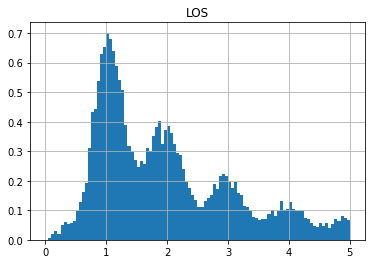

In [ ]:
data.hist(column="LOS", bins = 100, range = (0, 5), density = True)

In [ ]:
data["LOS"].describe()

count    20885.000000
mean         3.701046
std          5.175721
min          0.056600
25%          1.165400
50%          2.020800
75%          3.915800
max        101.739000
Name: LOS, dtype: float64

Is the chance of dying a feature that would be nice to have?

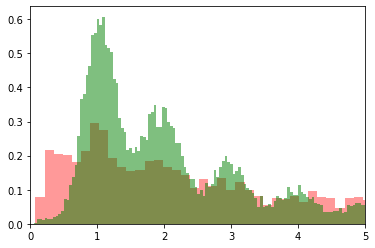

In [ ]:
dies = data[data["HOSPITAL_EXPIRE_FLAG"] ==1]["LOS"]
surv = data[data["HOSPITAL_EXPIRE_FLAG"] ==0]["LOS"]
plt.hist(dies, alpha=0.4, density= True, bins = 500, color = "red")
plt.hist(surv, alpha=0.5, density= True, bins = 2500, color = "green")
plt.xlim(0,5)
plt.show()


Yes, since the distributions are quite different.

Is the fact that the patient has come before a feature that we would like to have?

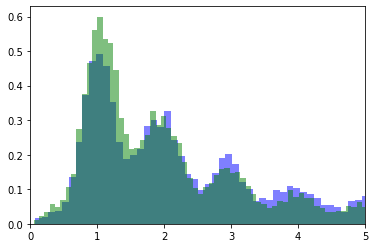

In [ ]:
data0 = data.sort_values(["subject_id", "ADMITTIME"])

rep = data0[data0["subject_id"].map(data0["subject_id"].value_counts()) >1]
non_rep = data0[data0["subject_id"].map(data0["subject_id"].value_counts()) == 1]


plt.hist(rep["LOS"], alpha=0.5, density= True, bins = 1000, color = "blue")
plt.hist(non_rep["LOS"], alpha=0.5, density= True, bins = 1000, color = "green")
plt.xlim(0,5)
plt.show()

Yes, repeat patients seem to have longer lengths of stay, the effect is more subtle than deaths though.

## Making data management simpler:

We rename some columns:

In [ ]:
data.rename(columns={'ICD9_diagnosis': 'ICD9_CODE'}, inplace=True)
test_data.rename(columns={'ICD9_diagnosis': 'ICD9_CODE'}, inplace=True)

data.rename(columns={'hadm_id': 'HADM_ID'}, inplace=True)
test_data.rename(columns={'hadm_id': 'HADM_ID'}, inplace=True)

We remove from the extra data, that which is about patients we do not have in our train or test sets.

In [ ]:
unique_patients_in_data = list(data['subject_id'].unique())
unique_patients_in_test_data = list(test_data['subject_id'].unique())
unique_patients = unique_patients_in_data + unique_patients_in_test_data
comorbidities = comorbidities.loc[comorbidities['SUBJECT_ID'].isin(unique_patients)]

## Dealing with datetime columns:

### We generate a column for the patient's age at admission time:

In [ ]:
# Function to compute and create a column for Age:
def get_age(df):

  a = list(range(0, df.shape[0], 1))
  age_col = []
  for i in a:
    dif1 = relativedelta(pd.to_datetime(df['ADMITTIME'][i]), pd.to_datetime(df['DOB'][i])).years
    dif2 = relativedelta(pd.to_datetime(df['ADMITTIME'][i]), pd.to_datetime(df['DOB'][i])).months
    dif3 = relativedelta(pd.to_datetime(df['ADMITTIME'][i]), pd.to_datetime(df['DOB'][i])).days
    dif = dif1 + dif2/12+dif3/365.25
    if dif > 120: #to normalize those with odd DOBs, who are 90 or older
      dif = 90
    age_col.append(dif)
  
  df['Age'] = age_col
  
  return df

for i in [data, test_data]:
  get_age(i)

### We correct the datetime offset:

In [ ]:
# Function to solve the datetimes offset:
def datetime_diff(df):
  
  df["DOB"] = pd.to_datetime(df["DOB"])
  df["DOB"] = df.apply(lambda x: x["DOB"] + pd.DateOffset(days=x["Diff"]), axis=1)
  df["DOB"] = df["DOB"].dt.floor("Min").dt.strftime("%Y-%m-%d %H:%M")

  df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"])
  df["ADMITTIME"] = df.apply(lambda x: x["ADMITTIME"] + pd.DateOffset(days=x["Diff"]), axis=1)
  df["ADMITTIME"] = df["ADMITTIME"].dt.floor("Min").dt.strftime("%Y-%m-%d %H:%M")

  return df

for i in [data, test_data]:
  datetime_diff(i)

### We generate more features out of `ADMITTIME`:

| New Feature | What is the idea?
|----------|---------------|
|Season of admission | Do patients stay longer in winter?         |        
|Year of admission | Are there specially complicated years?           |    
|Month of admission| Do doctors still have energy by July?       |    
|Weekday of admission | Is it more dangerous to be admitted a Sunday than a Wednesday?        |           
|Hour of admission | Is it more likely to have to stay a few extra hours if you were admitted at 3am?        |

In [ ]:
def season(month):
   seasons = ["Winter", "Spring", "Summer", "Autumn"]
   return seasons[np.floor((month-1)/3)]

def time_cols(df):
  df["ADM_year"] = pd.DatetimeIndex(df["ADMITTIME"]).year
  df["ADM_month"] = pd.DatetimeIndex(df["ADMITTIME"]).month
  df["ADM_weekday"] = pd.DatetimeIndex(df["ADMITTIME"]).weekday
  df["ADM_hour"] = pd.DatetimeIndex(df["ADMITTIME"]).hour 

  df["ADM_season"] = df.apply(lambda x: season(x.ADM_month),axis=1)

for df in [data, test_data]:
  time_cols(df)

### Patients that have been in hospital before:

In [ ]:
#this generates a new column with a 0 if this is the first time the patient is admitted or a 1 if it is not.
def rep(df):
  data0 = df.sort_values(["subject_id", "ADMITTIME"])

  listita = [0]
  for i in list(range(1, df.shape[0])):
    if data0.iloc[i,1] == data0.iloc[i-1,1]:
      listita.append(1)
    else:
      listita.append(0)

  data0["repeat"] = listita

  df = data0
  return df.sort_values(["subject_id", "ADMITTIME"]).sort_index(axis = 0)
 
data = rep(data)
test_data = rep(test_data)

### Expanding `LOS` to get more features:

Of course, `LOS` is what we want to predict. But would it be a good idea to split the prediction into two? For instance:

- One model predicts how many days the patient is going to stay.
- Another predicts time of discharge.

You then join the two for your final `LOS` prediction.

In [ ]:
def open_LOS(df):

  df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"])
  df["DISCHARGE"] = df.apply(lambda x: x["ADMITTIME"] + pd.DateOffset(days=x["LOS"]), axis=1)
  df["DISCHARGE"] = df["DISCHARGE"].dt.floor("Min").dt.strftime("%Y-%m-%d %H:%M")
  df["DIS_weekday"] = pd.DatetimeIndex(df["ADMITTIME"]).weekday
  df["DIS_hour"] = pd.DatetimeIndex(df["ADMITTIME"]).hour 

open_LOS(data)

1.0365437158469946

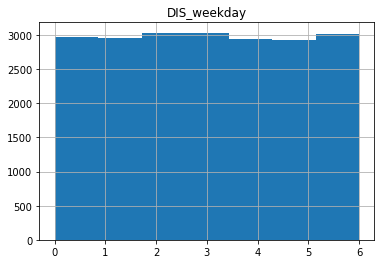

In [ ]:
data.hist(column="DIS_weekday",bins = 7)
max(data["DIS_weekday"].value_counts())/min(data["DIS_weekday"].value_counts())

There does not seem to be a day of the week in which being discharged is significantly more/less likely.

1.1383108935128519

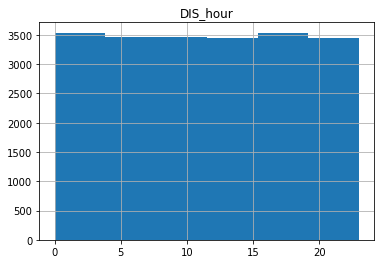

In [ ]:
data.hist(column="DIS_hour", bins=6)
max(data["DIS_hour"].value_counts())/min(data["DIS_hour"].value_counts())

Although there is a 13% difference between the less and most frequent hour of discharge, the histogram does not seem to indicate that there is a signal there. We therefore abbandon this idea.

<a name="merging"></a>

# <font color='blue'> Merging the additional data (comorbidities) with our two main dataframes:</font>

<font color='red'>*You can skip this section and directly load the prepared data*

In this section, we:
- Build the dataframes with the data to merge.
- Merge the dataframes and further clean.


### Adding the number of comorbidities a patient has. `SEQ_NUM`

In [ ]:
dseq = comorbidities[["HADM_ID", "SEQ_NUM"]]
dseq = dseq.groupby(['HADM_ID'], as_index=False).max()
data = data.merge(dseq, on='HADM_ID', how='left')
test_data = test_data.merge(dseq, on='HADM_ID', how='left')
print(data.shape)
print(test_data.shape)

(20885, 52)
(5221, 47)


## Building the dataframes to later merge:

The additional data offers the comorbidities people had at the time of admission. 

We will add this information to our main dataframes considering two types of comorbidities:

- Those that help predict probability of death. Here, we consider single comorbidities and also try to capture the synergic effect they have when simultaneously present.

- Those that help predict `LOS`, which are not necessarily the same ones.

###Single comorbidities:

We construct a df of the form:
- HADM_ID
- Dummified 5849 comorbs

In [ ]:
de = pd.get_dummies(comorbidities)
print(de.shape)

(385240, 5852)


In [ ]:
de = de.drop(["SUBJECT_ID", "SEQ_NUM"], axis=1)

The following avoids the program crashing due to RAM limitations:

In [ ]:
names = []
for i in list(range(1, len(list(de.columns)))):
  names.append(list(de.columns)[i][10:])

dic = dict(zip(list(de.columns)[1:], names))
de = de.rename(columns=dic)

In [ ]:
de_1 = de.head(30000)
de_1 = de_1.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de_2 = de[30000:60000]
de_2 = de_2.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de_3 = de[60000:100000]
de_3 = de_3.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de_4 = de[100000:150000]
de_4 = de_4.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de_5 = de[150000:200000]
de_5 = de_5.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de_6 = de[200000:250000]
de_6 = de_6.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de_7 = de[250000:300000]
de_7 = de_7.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de_8 = de[300000:]
de_8 = de_8.groupby(['HADM_ID'], as_index=False).sum()

In [ ]:
de = pd.concat([de_1, de_2, de_3, de_4, de_5, de_6, de_7, de_8])
de = de.groupby(['HADM_ID'], as_index=False).sum()
de.shape

(27558, 5850)

In [ ]:
print(de.shape)
de.head(5)

(27558, 5850)


,HADM_ID,0030,0031,0038,0039,0041,00581,0059,0071,0074,00804,00841,00843,00845,00847,0085,00862,00863,00869,0088,0090,0091,0092,0093,01123,01164,01186,01190,01194,01205,01300,01304,01325,01330,01354,01402,01405,01485,01504,01505,...,V8489,V850,V851,V8521,V8522,V8523,V8524,V8525,V8530,V8531,V8532,V8533,V8534,V8535,V8536,V8537,V8538,V8539,V854,V8541,V8542,V8543,V8544,V8545,V860,V861,V8709,V872,V8741,V8745,V8801,V8811,V8812,V8821,V9010,V902,V9039,V9081,V9089,V9103
0,100001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100010,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100011,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Pairwise interactions - Used for Death prediction:

We construct a dataframe of the form:
- HADM_ID
- Dummified possible combinations between the top 100 deadliest comorbidities (4950 features).
- named: de_pair

In [ ]:
n = 100
died = data.loc[data['HOSPITAL_EXPIRE_FLAG'] == 1]
who_died = died['HADM_ID']

what_kills = comorbidities.loc[comorbidities['HADM_ID'].isin(who_died)]

top_killers = what_kills['ICD9_CODE'].value_counts()[:n].index.tolist()

all_combinations = list(itertools.combinations(top_killers, 2))


name_col = []
col_1 = []
col_2 = []
for (i, j) in all_combinations:
  
  name_col.append(i+"+"+j)
  col_1.append(i)
  col_2.append(j)
dic = {'Pair': name_col, '1': col_1, '2': col_2}

dic = pd.DataFrame(dic)

num = list(range(0, len(dic['Pair']),1))

from progressbar import ProgressBar
pbar = ProgressBar()

de_pair = de.copy()

for i in pbar(num):

  de_pair[dic['Pair'][i]] = np.where(de[dic['1'][i]] + de[dic['2'][i]] == 2, 1, 0)
 

100% (4950 of 4950) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


### Single comorbidities for Death prediction:
Dataframe of the form:
- HADM_ID
- Dummified top 100 most present comorbilities in those who die
- Named: de1

In [ ]:
top = 100
de1 = de[list(what_kills.ICD9_CODE.value_counts().index)[:top]+["HADM_ID"]]

### Single comorbidities for LOS prediction:
We identify the top 150 most relevant comorbidities for LOS. 

To do so, we divide LOS into Short and Long Stays, considering the median as the threshold: 50% of observations will be of each type.


In [ ]:
data1 = data
data1 = data1[["HADM_ID", "LOS"]]
data1["Short_stay"] = np.where(data1["LOS"] < 2.0208, 1, 0)
print("proportion of short stays: ", sum(data1["Short_stay"])/len(data1["Short_stay"]))
data1 = data1.merge(de, on='HADM_ID', how='left')

def most_freq(a):
  data2 = data1[data1["Short_stay"] == a]


  freqs = []
  comorb = list(data2.columns)[3:]
  for i in comorb:
    freqs.append(sum(data2[i]))


  zipped = list(zip(comorb, freqs))
  comorb_in_short_stays = pd.DataFrame(zipped, columns=['Comorb', 'Freq'])
  
  return comorb_in_short_stays

ss = most_freq(1)
ls = most_freq(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


proportion of short stays:  0.4999281781182667


We now analyse which comorbidities are more present in short and long stays. 

Since some comorbidities are present in both cases, we generate a ratio between frequencies.
We keep only those comorbidities that are 75% more likely to be present in short or long stays:

- 10 comorbidities are more likely when the stay is short.
- 140 when the stay is long.

In [ ]:
ss.rename(columns={'Freq': 'Freq_ss'}, inplace=True)
ls.rename(columns={'Freq': 'Freq_ls'}, inplace=True)
ls1 = ls.drop(["Comorb"], axis=1)
top_comorbs = pd.concat([ss, ls1], axis=1)
top_comorbs = top_comorbs[top_comorbs["Freq_ss"]>25] # to remove infrequent comorbidities
top_comorbs = top_comorbs[top_comorbs["Freq_ls"]>25] # to remove infrequent comorbidities
top_comorbs["sum"] = top_comorbs["Freq_ss"] + top_comorbs["Freq_ls"]

top_comorbs["ratio"] = (top_comorbs["Freq_ss"] / top_comorbs["Freq_ls"])
top_comorbs = top_comorbs.sort_values(by=['ratio'], ascending=False)

print(top_comorbs.shape)

x = 10

top_comorbs_ss = list(top_comorbs.head(x)["Comorb"])
top_comorbs_ls = list(top_comorbs.tail(150-x)["Comorb"])

top_comorbs_stay = top_comorbs_ss + top_comorbs_ls #these are the most relevant comorbidities for LOS prediction

(698, 5)


### Pairwise comorbidities for Death prediction:
Dataframe of the form:
- HADM_ID
- Dummified top 100 most present pair of comorbilities in those who die
- Named: de_pair

In [ ]:
de_pair1 = de_pair[de_pair['HADM_ID'].isin(who_died)]
de_pair1.head(5)

,HADM_ID,0030,0031,0038,0039,0041,00581,0059,0071,0074,00804,00841,00843,00845,00847,0085,00862,00863,00869,0088,0090,0091,0092,0093,01123,01164,01186,01190,01194,01205,01300,01304,01325,01330,01354,01402,01405,01485,01504,01505,...,5722+V1254,5722+42832,5722+30000,5722+79092,99591+43491,99591+2930,99591+V103,99591+2639,99591+V1254,99591+42832,99591+30000,99591+79092,43491+2930,43491+V103,43491+2639,43491+V1254,43491+42832,43491+30000,43491+79092,2930+V103,2930+2639,2930+V1254,2930+42832,2930+30000,2930+79092,V103+2639,V103+V1254,V103+42832,V103+30000,V103+79092,2639+V1254,2639+42832,2639+30000,2639+79092,V1254+42832,V1254+30000,V1254+79092,42832+30000,42832+79092,30000+79092
23,100061,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,100074,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
35,100098,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57,100197,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65,100223,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
leave = 100

print(len((who_died.unique())))
de_pair1 = de_pair[de_pair['HADM_ID'].isin(who_died)]
sums = []
for i in list(de_pair1.columns)[5850:]:
  sums.append(de_pair1[i].sum())
auxdf = pd.DataFrame({"ColName": list(de_pair1.columns)[5850:], "Sum": sums})
auxdf = auxdf.sort_values(by="Sum", ascending=False)
auxdf = auxdf.head(leave)
leave_these_columns = ['HADM_ID'] + list(auxdf['ColName'])


2093


In [ ]:
de_pair = de_pair[leave_these_columns]
de_pair.head(2)
#de_pair['99592+0389'].sum()


,HADM_ID,99592+0389,99592+78552,51881+99592,51881+5849,42731+4280,51881+4019,51881+42731,51881+0389,0389+78552,5849+99592,51881+4280,51881+78552,51881+2762,4019+42731,5849+4280,42731+5849,4019+5849,99592+2762,5849+2762,4019+2724,42731+99592,5849+0389,51881+486,99592+4280,4019+25000,51881+25000,5849+78552,4019+99592,40390+5859,4019+4280,42731+2762,2762+0389,51881+V4986,4019+2762,4280+41401,51881+2724,4019+V4986,42731+V5861,42731+2724,...,99592+5845,5849+40390,4280+78552,4019+41401,5849+2724,4280+486,5849+5990,4280+5859,51881+2875,99592+486,42731+486,5849+V4986,5849+5859,5849+41401,2762+5845,51881+4275,42731+40390,4019+78552,V4986+2724,42731+5990,99592+25000,2724+25000,4280+V4986,5849+V667,0389+486,99592+2875,2724+41401,4019+486,51881+40390,4280+V5861,51881+2760,42731+V667,5849+2875,51881+2761,99592+5990,78552+5845,42731+5859,42731+5845,2762+25000,51881+496
0,100001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Merging the dataframes and further cleaning:


At this point, we add to the main dataframes the addition information relevant for Death prediction. Later on, we will remove these features and add those pertinent for LOS.

In [ ]:
print("data was: " + str(data.shape))
print("test_data was: " + str(test_data.shape))
data = data.merge(de1, on='HADM_ID', how='left')
data = data.merge(de_pair, on='HADM_ID', how='left')

test_data = test_data.merge(de1, on='HADM_ID', how='left')
test_data = test_data.merge(de_pair, on='HADM_ID', how='left')

print("data now is: " + str(data.shape))
print("test_data now is: " + str(test_data.shape))

data was: (20885, 52)
test_data was: (5221, 47)
data now is: (20885, 252)
test_data now is: (5221, 247)


Since the training data has more columns than the test data, we remove those which do not intersect:

In [ ]:
print("data was: " + str(data.shape))
print("test_data was: " + str(test_data.shape))
a = list(data.columns)
b = list(test_data.columns)
all_columns = a + b 

unique_columns = [i for i in all_columns if all_columns.count(i)==1]

unique_columns.remove("HOSPITAL_EXPIRE_FLAG")
unique_columns.remove("LOS")
data = data.drop(unique_columns, axis=1)

print("data now is: " + str(data.shape))
print("test_data now is: " + str(test_data.shape))

data was: (20885, 252)
test_data was: (5221, 247)
data now is: (20885, 249)
test_data now is: (5221, 247)


We drop some features, from both the training and test data, that are no longer useful:

In [ ]:
data = data.drop(['subject_id', 'icustay_id', "DOB", "Diff", "ADMITTIME", "DIAGNOSIS", "ICD9_CODE"], axis=1)
test_data = test_data.drop(['subject_id', 'icustay_id', "DOB", "Diff", "ADMITTIME", "DIAGNOSIS", "ICD9_CODE"], axis=1)

<a name="further"></a>
# <font color='blue'> Further data processing:</font>

<font color='red'>*You can skip this section and directly load the prepared data*

In this group of blocks, we deal with:

- Missing data
- Categorical features

## Dealing with missing data (NAs):

We check for null values in data and test_data:

In [ ]:
Nulls = data.isnull().sum()
print(Nulls)
Nulls1 = test_data.isnull().sum()
print(Nulls1)

HOSPITAL_EXPIRE_FLAG       0
HADM_ID                    0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
                        ... 
78552+5845                 0
42731+5859                 0
42731+5845                 0
2762+25000                 0
51881+496                  0
Length: 242, dtype: int64
HADM_ID             0
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
                 ... 
78552+5845          0
42731+5859          0
42731+5845          0
2762+25000          0
51881+496           0
Length: 240, dtype: int64


There are many NAs so we will use placeholders, through Sklearn's SimpleImputer.

For numerical missing values, the strategy will be to use the mean. This implies replacing every NA, in every column with one, with the mean of that column.

Others stategies (median, mode) were tested but did not yield significant enhancements in performance.

Split dataframes into 2 (one with numerical cols, one with categorical cols):

In [ ]:
numeric_cols = data.select_dtypes(include=np.number).columns.tolist()
numeric_cols1 = test_data.select_dtypes(include=np.number).columns.tolist()

data_num = data[numeric_cols]
#further separation so that the numerical columns in data and test_data are the same
data_num1 = data_num[["LOS", "HOSPITAL_EXPIRE_FLAG"]]
data_num2 = data_num.drop(["LOS", "HOSPITAL_EXPIRE_FLAG"], axis =1)

data_cat = data.drop(numeric_cols, axis=1)


test_data_num = test_data[numeric_cols1]

test_data_cat = test_data.drop(numeric_cols1, axis=1)

In [ ]:
#we store the name of the columns:

data_num1_colnames = data_num1.columns
data_num2_colnames = data_num2.columns
test_data_num_colnames = test_data_num.columns

Import, train and apply SimpleImputer:

In [ ]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

imp_mean.fit(data_num2)

data_num2 = pd.DataFrame(imp_mean.transform(data_num2)) 
test_data_num = pd.DataFrame(imp_mean.transform(test_data_num))

Note how we apply the same fitted imputer -with df.data- to data and test_data.

We reassign names to the columns:



In [ ]:
data_num1.columns = data_num1_colnames
data_num2.columns = data_num2_colnames
test_data_num.columns = test_data_num_colnames
data_num.head(2)

,HOSPITAL_EXPIRE_FLAG,HADM_ID,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,LOS,Age,ADM_year,ADM_month,ADM_weekday,ADM_hour,repeat,SEQ_NUM,51881,4019,42731,5849,99592,4280,...,99592+5845,5849+40390,4280+78552,4019+41401,5849+2724,4280+486,5849+5990,4280+5859,51881+2875,99592+486,42731+486,5849+V4986,5849+5859,5849+41401,2762+5845,51881+4275,42731+40390,4019+78552,V4986+2724,42731+5990,99592+25000,2724+25000,4280+V4986,5849+V667,0389+486,99592+2875,2724+41401,4019+486,51881+40390,4280+V5861,51881+2760,42731+V667,5849+2875,51881+2761,99592+5990,78552+5845,42731+5859,42731+5845,2762+25000,51881+496
0,0,195768,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,4.5761,69.557495,2008,6,6,15,0,17.0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,126136,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,0.7582,42.073922,2010,12,0,18,0,3.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we rejoin each dataframe:

In [ ]:
data_num = pd.concat([data_num1, data_num2], axis=1, join="inner")
data = pd.concat([data_cat, data_num], axis=1, join="inner")
test_data = pd.concat([test_data_cat, test_data_num], axis=1, join="inner")

In [ ]:
data.head(2)

,GENDER,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,FIRST_CAREUNIT,ADM_season,LOS,HOSPITAL_EXPIRE_FLAG,HADM_ID,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Age,ADM_year,ADM_month,ADM_weekday,ADM_hour,...,99592+5845,5849+40390,4280+78552,4019+41401,5849+2724,4280+486,5849+5990,4280+5859,51881+2875,99592+486,42731+486,5849+V4986,5849+5859,5849+41401,2762+5845,51881+4275,42731+40390,4019+78552,V4986+2724,42731+5990,99592+25000,2724+25000,4280+V4986,5849+V667,0389+486,99592+2875,2724+41401,4019+486,51881+40390,4280+V5861,51881+2760,42731+V667,5849+2875,51881+2761,99592+5990,78552+5845,42731+5859,42731+5845,2762+25000,51881+496
0,F,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,MICU,Spring,4.5761,0,195768.0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,69.557495,2008.0,6.0,6.0,15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,MICU,Autumn,0.7582,0,126136.0,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,42.073922,2010.0,12.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#check for nulls:
Nulls = sum(data.isnull().sum())
print(Nulls)

722


Dealing with Marital Status' NAs:

We reclassify NAs as the category "UNKNOWN (DEFAULT)":

In [ ]:
data['MARITAL_STATUS'].unique()

array(['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED', nan,
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

In [ ]:
data.MARITAL_STATUS.fillna('UNKNOWN (DEFAULT)', inplace=True)
data['MARITAL_STATUS'].unique()

array(['SINGLE', 'MARRIED', 'SEPARATED', 'WIDOWED', 'DIVORCED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

We check if there are any more NAs in the "data" dataframe:

In [ ]:
Nulls = data.isnull().sum()
print(sum(Nulls))

0


Solving the NA problem for the test_data. This is the same process as above:

In [ ]:
test_data.MARITAL_STATUS.fillna('UNKNOWN (DEFAULT)', inplace=True)
test_data['MARITAL_STATUS'].unique()

array(['MARRIED', 'WIDOWED', 'SINGLE', 'DIVORCED', 'UNKNOWN (DEFAULT)',
       'SEPARATED', 'LIFE PARTNER'], dtype=object)

In [ ]:
#check it worked:
sum(test_data.isnull().sum())

0

##Dealing with categorical features:

We analyze the nature of the following categorical features:
- GENDER
- ADMISSION_TYPE
- INSURANCE
- RELIGION
- MARITAL STATUS
- ETHNICITY
- DIAGNOSIS
- FIRST_CAREUNIT

We check if few categories gather most of the cases, if they are binary or multiclass, etc.

In [ ]:
list = ['GENDER', 'ADMISSION_TYPE','INSURANCE', 'RELIGION','MARITAL_STATUS',
                        'ETHNICITY', 'FIRST_CAREUNIT']
for i in list:
  print(data[i].unique())

['F' 'M']
['EMERGENCY' 'ELECTIVE' 'URGENT']
['Medicare' 'Private' 'Medicaid' 'Self Pay' 'Government']
['PROTESTANT QUAKER' 'UNOBTAINABLE' 'NOT SPECIFIED' 'JEWISH' 'CATHOLIC'
 'OTHER' 'BUDDHIST' 'EPISCOPALIAN' 'ROMANIAN EAST. ORTH' 'GREEK ORTHODOX'
 "JEHOVAH'S WITNESS" 'MUSLIM' 'CHRISTIAN SCIENTIST' 'HINDU'
 '7TH DAY ADVENTIST' 'UNITARIAN-UNIVERSALIST' 'HEBREW']
['SINGLE' 'MARRIED' 'SEPARATED' 'WIDOWED' 'DIVORCED' 'UNKNOWN (DEFAULT)'
 'LIFE PARTNER']
['WHITE' 'BLACK/AFRICAN AMERICAN' 'BLACK/CAPE VERDEAN'
 'UNKNOWN/NOT SPECIFIED' 'PATIENT DECLINED TO ANSWER'
 'ASIAN - ASIAN INDIAN' 'OTHER' 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN'
 'HISPANIC OR LATINO' 'UNABLE TO OBTAIN' 'BLACK/HAITIAN'
 'WHITE - OTHER EUROPEAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'WHITE - RUSSIAN' 'WHITE - EASTERN EUROPEAN' 'ASIAN - CHINESE'
 'HISPANIC/LATINO - CUBAN' 'ASIAN - VIETNAMESE' 'MULTI RACE ETHNICITY'
 'AMERICAN INDIAN/ALASKA NATIVE' 'MIDDLE EASTERN' 'ASIAN - KOREAN'
 'CARIBBEAN ISLAND' 'PORTUGUESE' 'H

Many plots like the following were used to see how to deal with multiclass variables:

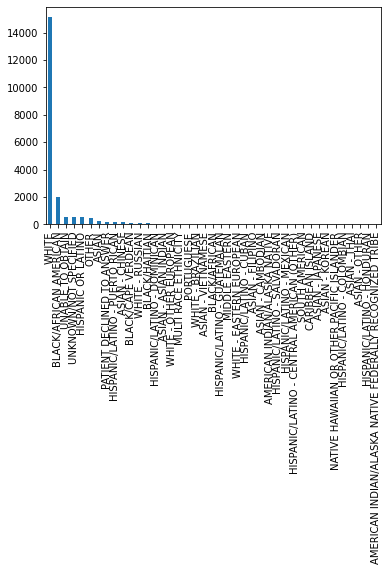

In [ ]:
data.ETHNICITY.value_counts().plot(kind="bar") 

For instance, it seems like a good idea to bundle some of the classes in the "Ethnicity" feature as "Other".

Through the previous analysis, we classify the features as:

- Binary: just get dummy.
    - GENDER
- Multiclass, with all classes present. Get dummies. 
    - ADMISSION_TYPE
    - INSURANCE
    - MARITAL STATUS
    - FIRST_CAREUNIT
    - SEASON
    - YEAR
    - WEEKDAY
    - HOUR
- Multiclass, with some classes that can be bundled together under "Other":
    - RELIGION
    - ETHNICITY


In [ ]:
data = data.drop(["ADM_month"], axis=1)
data = pd.get_dummies(data, prefix=['Season'], columns=['ADM_season'], drop_first = True)
data = pd.get_dummies(data, prefix=['y'], columns=['ADM_year'], drop_first = True)
data = pd.get_dummies(data, prefix=['wd'], columns=['ADM_weekday'], drop_first = True)
data = pd.get_dummies(data, prefix=['h'], columns=['ADM_hour'], drop_first = True)



In [ ]:
test_data = test_data.drop(["ADM_month"], axis=1)
test_data = pd.get_dummies(test_data, prefix=['Season'], columns=['ADM_season'], drop_first = True)
test_data = pd.get_dummies(test_data, prefix=['y'], columns=['ADM_year'], drop_first = True)
test_data = pd.get_dummies(test_data, prefix=['wd'], columns=['ADM_weekday'], drop_first = True)
test_data = pd.get_dummies(test_data, prefix=['h'], columns=['ADM_hour'], drop_first = True)


In [ ]:
# for the data:
data = pd.get_dummies(data = data, columns=['GENDER'], drop_first = True)

data = pd.get_dummies(data, prefix=['ADM_TYPE'], columns=['ADMISSION_TYPE'], drop_first = True)

eth_list = []
for j in data['ETHNICITY']:
  if j == "WHITE":
    eth_list.append("WHITE")
  elif j == "BLACK/AFRICAN AMERICAN":
    eth_list.append("BLACK/AFRICAN AMERICAN")
  else:
    eth_list.append("OTHER")
data = data.drop(["ETHNICITY"], axis=1)
data["ETHNICITY"] = eth_list
data = pd.get_dummies(data, prefix=['ETH'], columns=['ETHNICITY'], drop_first = True)

data = pd.get_dummies(data, prefix=['MARITAL'], columns=['MARITAL_STATUS'], drop_first = True)

rel = []
for k in data['RELIGION']:
  if k == "CATHOLIC":
    rel.append("CATHOLIC")
  elif k == "PROTESTANT QUAKER":
    rel.append("PROTESTANT QUAKER")
  elif k == "JEWISH":
    rel.append("JEWISH")
  else:
    rel.append("OTHER")
data = data.drop(["RELIGION"], axis=1)
data["RELIGION"] = rel
data = pd.get_dummies(data, prefix=['REL'], columns=['RELIGION'], drop_first = True)

data = pd.get_dummies(data, prefix=['INS'], columns=['INSURANCE'], drop_first = True)

data = pd.get_dummies(data, prefix=['CAREUNIT'], columns=['FIRST_CAREUNIT'], drop_first = True)

#data = data.drop(["DIAGNOSIS"], axis=1)
#data = data.drop(["ICD9_CODE"], axis=1)

In [ ]:
# for the test_data
test_data = pd.get_dummies(data = test_data, columns=['GENDER'], drop_first = True)

test_data = pd.get_dummies(test_data, prefix=['ADM_TYPE'], columns=['ADMISSION_TYPE'], drop_first = True)

eth_list = []
for j in test_data['ETHNICITY']:
  if j == "WHITE":
    eth_list.append("WHITE")
  elif j == "BLACK/AFRICAN AMERICAN":
    eth_list.append("BLACK/AFRICAN AMERICAN")
  else:
    eth_list.append("OTHER")
test_data = test_data.drop(["ETHNICITY"], axis=1)
test_data["ETHNICITY"] = eth_list
test_data = pd.get_dummies(test_data, prefix=['ETH'], columns=['ETHNICITY'], drop_first = True)

test_data = pd.get_dummies(test_data, prefix=['MARITAL'], columns=['MARITAL_STATUS'], drop_first = True)

rel = []
for k in test_data['RELIGION']:
  if k == "CATHOLIC":
    rel.append("CATHOLIC")
  elif k == "PROTESTANT QUAKER":
    rel.append("PROTESTANT QUAKER")
  elif k == "JEWISH":
    rel.append("JEWISH")
  else:
    rel.append("OTHER")
test_data = test_data.drop(["RELIGION"], axis=1)
test_data["RELIGION"] = rel
test_data = pd.get_dummies(test_data, prefix=['REL'], columns=['RELIGION'], drop_first = True)

test_data = pd.get_dummies(test_data, prefix=['INS'], columns=['INSURANCE'], drop_first = True)

test_data = pd.get_dummies(test_data, prefix=['CAREUNIT'], columns=['FIRST_CAREUNIT'], drop_first = True)

#test_data = test_data.drop(["DIAGNOSIS"], axis=1)
#test_data = test_data.drop(["ICD9_CODE"], axis=1)

We check final dimensions:

In [ ]:
print(data.shape)
print(test_data.shape)

(20885, 289)
(5221, 287)


In [ ]:
data.head(2)

,LOS,HOSPITAL_EXPIRE_FLAG,HADM_ID,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Age,repeat,SEQ_NUM,51881,4019,42731,5849,99592,4280,2762,0389,V4986,78552,...,h_6.0,h_7.0,h_8.0,h_9.0,h_10.0,h_11.0,h_12.0,h_13.0,h_14.0,h_15.0,h_16.0,h_17.0,h_18.0,h_19.0,h_20.0,h_21.0,h_22.0,h_23.0,GENDER_M,ADM_TYPE_EMERGENCY,ADM_TYPE_URGENT,ETH_OTHER,ETH_WHITE,MARITAL_LIFE PARTNER,MARITAL_MARRIED,MARITAL_SEPARATED,MARITAL_SINGLE,MARITAL_UNKNOWN (DEFAULT),MARITAL_WIDOWED,REL_JEWISH,REL_OTHER,REL_PROTESTANT QUAKER,INS_Medicaid,INS_Medicare,INS_Private,INS_Self Pay,CAREUNIT_CSRU,CAREUNIT_MICU,CAREUNIT_SICU,CAREUNIT_TSICU
0,4.5761,0,195768.0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,69.557495,0.0,17.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0
1,0.7582,0,126136.0,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,42.073922,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0


##Save to csv, for faster code runs in the future:

In [ ]:
data.to_csv(path_or_buf='data.csv', index=False)
test_data.to_csv(path_or_buf='test_data.csv', index=False)

<a name="models"></a>
#<font color='blue'> Models!</font> 
<font color='red'>*You can quickly load the output of the previous sections here*</font>

In this section we fit our models, check accuracy and generate predictions.




Two main predictions were made:

1. Death predictions: we used the HOSPITAL_EXPIRE_FLAG data in our training set to predict if patients in our test set would die. <font color='green'>Classification problem</font>.

2. LOS predictions: we used the previous predictions -and all the other pertinent features- to predict lengths of stay. <font color='green'>Regression problem</font>.

Many features are shared by both cases, but **most of them are specific to what we want to predict**.







We use the following models:

- Random Forest Classifier.
- Balanced Random Forest Classifier.
- Stacking:
  - Weak learners:
    - KNN.
    - LinearSVR.
    - Random Forest Regressor.
  - Meta learner: Extra Trees Regressor
- XGBoosting.
- Bagged XGBoosters.



In [ ]:
#fast data loading:

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/CM1_CM2_learning/CML_materials/ensembles/kaggle')

import pandas as pd
import numpy as np

data = pd.read_csv("data.csv")
test_data = pd.read_csv("test_data.csv")

Mounted at /content/drive


## 1. Death prediction:

As we saw in our Quick Analysis section - and as common sense indicates - patients who die disrupt their stay so estimating if a patient will die is a good feature for LOS regressing.

We will try a few bagged classifiers to predict the probability of death of patients and add that information to our datasets.

Note we do not use the LOS column.

###Prepping the data:

In [ ]:
X = data.drop(["HOSPITAL_EXPIRE_FLAG", "LOS", "HADM_ID"], axis =1)
y = data["HOSPITAL_EXPIRE_FLAG"]
X_test = test_data.drop(["HADM_ID"], axis =1)
print(X.shape)
X_test.shape

(20885, 286)


(5221, 286)

### Models for Classification:

Trying a Random Forest Classifier:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators = 150, 
                                criterion = "entropy",
                                max_features = "sqrt",
                                n_jobs = 8,
                                verbose = 0,
                                class_weight = "balanced_subsample") #for class imbalance

#Grid Search performed to determine above hyperparameters:

#parameters = {'n_estimators': [150],
              #'criterion':["gini", "entropy"],
              #'max_features':["sqrt", "log2"],
              #'class_weight': ["balanced", "balanced_subsample"]}

#best_rfc = GridSearchCV(forest, parameters, cv=3, scoring='roc_auc', n_jobs = 8, verbose=3, refit=True)
#best_rfc.fit(X, y)
#best_rfc.best_params_

scores = cross_val_score(forest, X, y, scoring='roc_auc', cv=5, n_jobs=-1)

print("Mean ROC AUC: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))


Mean ROC AUC: 0.930 (+/- 0.009)


Note that the RFC's hyperparameters were grid-searched and that the area under the curve of the ROC was the score which we wanted to maximize (since it is a classification problem).

We also tried out another set of models (Balanced RFC), which perform random undersampling of the majority class in each bootstrap sample to deal with the class imbalance:

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier 
model = BalancedRandomForestClassifier(n_estimators = 200,
                                        criterion = "entropy",
                                        max_features = "sqrt",
                                        n_jobs = 8,
                                        verbose = 0)

#Grid Search performed to determine above hyperparameters:

#parameters = {'n_estimators': [50, 100, 150, 200],
              #'criterion':["gini", "entropy"],
              #'max_features':["sqrt", "log2"]}

#best_model = GridSearchCV(model, parameters, cv=5, scoring='roc_auc', n_jobs = 8, verbose=3, refit=True)
#best_model.fit(X, y)
#best_model.best_params_

scores = cross_val_score(model, X, y, scoring='roc_auc', cv=5, n_jobs=-1)

print("Mean ROC AUC: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Mean ROC AUC: 0.922 (+/- 0.008)


Again, the hyperparameters were grid-searched and the accuracy measured with a mean ROC AUC.

### Prediction of death:

We will use the Random Forest Classifier since it appears to perform slightly better:

In [ ]:
forest.fit(X,y)
prob_death = pd.DataFrame(forest.predict_proba(X_test), columns=['Column1', "HOSPITAL_EXPIRE_FLAG"]) 

In [ ]:
#to see how it looks:
prob_death.head(2)

,Column1,HOSPITAL_EXPIRE_FLAG
0,0.980000,0.020000
1,0.833333,0.166667


##2. LOS prediction:

### Prepping the data:

<font color='red'>*You can skip this section and directly load the prepared data*

We add our freshly baked probability of death feature to our test set and redefine X and y:

In [ ]:
X = data.drop(["LOS"], axis =1)
y = data["LOS"]
X_test = pd.concat([prob_death["HOSPITAL_EXPIRE_FLAG"], test_data], axis=1)

We drop all the features that made sense for predicting death, and replace them with the ones that make sense for predicting LOS:


In [ ]:
#dropping features for death:
print("initial X: ", X.shape)
print("initial X_test: ", X_test.shape)

droppable = X.iloc[:, 29:229].columns

#this drops the top 100 single comorbidities present in patients who die and 
#the top 100 pairwise combinations of comorbidities present in patients who die:
X = X.drop(droppable, axis=1) 

#this does the same for the testset:
X_test = X_test.drop(droppable, axis=1)


print("X after dropping: ", X.shape)
print("X_test after dropping: ", X_test.shape)

initial X:  (20885, 288)
initial X_test:  (5221, 288)
X after dropping:  (20885, 88)
X_test after dropping:  (5221, 88)


In [ ]:
#adding features for LOS:
top_comorbs_stay.append("HADM_ID")
de2 = de[top_comorbs_stay]

#this adds the top 150 comorbidities that are distinctly more likely to be present in short and long stay patients: 
X = X.merge(de2, on='HADM_ID', how='left')
X_test = X_test.merge(de2, on='HADM_ID', how='left')

print("X after adding: ", X.shape)
print("X_test after adding: ", X_test.shape)

X after adding:  (20885, 238)
X_test after adding:  (5221, 238)


In [ ]:
#this drops HADM_ID which has no use now:
X = X.drop(["HADM_ID"], axis =1)
X_test = X_test.drop(["HADM_ID"], axis =1)

Save the output for future runs.

In [ ]:
X.to_csv(path_or_buf='X_for_LOS.csv', index=False)
X_test.to_csv(path_or_buf='X_test_for_LOS.csv', index=False)
y.to_csv(path_or_buf='yfor_LOS.csv', index=False)

### Regression Models:


<font color='red'>*Quickly load the output of the previous section*

In [ ]:
#quick load

X = pd.read_csv('X_for_LOS.csv')
X_test = pd.read_csv('X_test_for_LOS.csv')
y = pd.read_csv('yfor_LOS.csv')
for i in [X, X_test, y]:
  print(i.shape)

(20885, 237)
(5221, 237)
(20885, 1)


#### Stacking:

As weak learners, we used k-Nearest Neighbors, a Support Vector Machine model and a Random Forest.

Pre-requisites:

In [ ]:
# Scale inputs for kNN and SVM

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [ ]:
# Split the data in order to measure accuracy of the models, since cross-validation would take too long.

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.15, random_state=123)

for i in [xtrain, xtest, ytrain, ytest]:
  print(i.shape)

(17752, 237)
(3133, 237)
(17752, 1)
(3133, 1)


1. KNN Regressor:

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=100)
knn.fit(xtrain, ytrain)
knnPred = knn.predict(xtest)
score = mean_squared_error(ytest, knnPred, squared= False)
print("RMSE kNN:", "%.3f" % (score))

RMSE kNN: 5.641


2. Linear SVR:

In [ ]:
from sklearn.svm import LinearSVR
svr = LinearSVR(C=10, verbose = 2) 
svr.fit(xtrain, ytrain)
svrPred = svr.predict(xtest)
score = mean_squared_error(ytest, svrPred, squared= False)
print("RMSE SVR:", "%.3f" % (score))

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE SVR: 5.091


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


3. Random Forest Regressor:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50, max_features=100, random_state=10) 
rf.fit(xtrain, ytrain)
rfPred = rf.predict(xtest)
score = mean_squared_error(ytest, rfPred, squared= False)
print("RMSE RF:", "%.3f" % (score))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RMSE RF: 4.601


We use an Extra Trees Regressor as the meta-learner:

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
meta_learner = ExtraTreesRegressor(
    n_estimators=50,
    bootstrap=True,
    max_features=0.7,
    random_state=5)

Actual stacking:

In [ ]:
!pip install mlens
from mlens.ensemble import SuperLearner
# Instantiate the ensemble with 5 folds (stacking meta-learner)
sl = SuperLearner(
    folds=5,
    random_state=123,
    verbose=2,
    backend="multiprocessing",
    n_jobs=3
)

# Add the base learners and the meta learner
sl.add([knn, svr, rf])
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
slPred = sl.predict(xtest)
score = mean_squared_error(ytest, slPred, squared= False)
print("RMSE SL:", "%.3f" % (score))

     |████████████████████████████████| 227 kB 5.0 MB/s 

Fitting 2 layers


[MLENS] backend: threading


Processing layer-1             

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklea

done | 00:02:47
Processing layer-2             done | 00:00:01
Fit complete                        | 00:02:49

Predicting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:04
RMSE SL: 4.763


Not very promising. But we fit the superlearner with all the data:

In [ ]:
# Train the ensemble
sl.fit(X, y)

# Predict the test set
slPred = sl.predict(X_test)


Fitting 2 layers
Processing layer-1             

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklea

done | 00:03:23
Processing layer-2             [LibLinear][LibLinear][LibLinear][LibLinear]done | 00:00:01
Fit complete                        | 00:03:26

Predicting 2 layers
Processing layer-1             done | 00:00:05
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:06


We inspect the predictions:

In [ ]:
pd.DataFrame(slPred).describe()

,0
count,5221.000000
mean,3.789525
std,3.503942
min,0.414092
25%,1.787720
50%,2.555444
75%,4.342220
max,37.160007


####XGBOOST:

We try out XGBOOST:

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

Gridsearch suggests very little changes to the default parameters:

In [ ]:
xgbr = xgb.XGBRegressor(verbosity = 0, eta = 0.1, max_depth=6, subsample=1)

#params = {"eta": [0.1, 0.2, 0.3],
 #         "max_depth": [3, 6, 8],
  #        "subsample": [0.8, 1]}

#search = GridSearchCV(xgbr, params, cv=5, n_jobs=8, scoring="neg_mean_squared_error")

#search.fit(X, y)

#search.best_params_
#search.best_score_

Nonetheless, the GridSearchCV was not very wide in order to save time. 

We try a different approach to complement these results: Bayesian Search. This technique uses Bayesian optimization to try to find some structure in the search space, and through it minimizes the search time. 

It uses the past evaluation results to sample new candidates that are more likely to give better results.

In [ ]:
!pip install scikit-optimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer

xgbr = xgb.XGBRegressor()

# we define the space for the parameter. for instance, "eta" is a real number between 0.1 and 0.5 and we want a uniform distribution as the prior.
# params = {"eta": Real(0.1, 0.5, prior = "uniform"),
  #        "max_depth": Integer(2, 8, prior = "uniform"),
   #       "subsample": Real(0.7, 1, prior = "uniform")}

#search = BayesSearchCV(xgbr, params, cv=5, n_jobs=8, n_iter = 10, scoring="neg_mean_squared_error")

#search.fit(X, y)

#search.best_params_
#search.best_score_

#xgbr.fit(X,y)

#LOS_pred = pd.DataFrame(xgbr.predict(X_test)) 

     |████████████████████████████████| 100 kB 2.9 MB/s 
[15:25:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


-16.90486311041289

Best scores were 4.15 RMSE for our simple grid search and 4.11 RSME for our Bayesian Grid Search. These are more promising than the one we got with Stacking. 

We use the hyperparameters suggested by BGS, fit our model and make predictions:

In [ ]:
xgbr = xgb.XGBRegressor(n_estimators = 200, eta = 0.29748707337902003, max_depth = 5, subsample = 0.7458870482611535)

xgbr.fit(X,y)

LOS_pred = pd.DataFrame(xgbr.predict(X_test)) 

[16:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Note that, since we have not set a seed, and due to the fact that we are regressing LOS that are in some cases close to zero, you might get some predictions with negative values. This will be "manually" corrected later on.

In my experience they are at most 2, out of the 5000+.

####Bagging XGBOOST:

If XGBOOST by itself is nice, imagine bagging it. 

The grid search suggests using the exact default parameters for BaggingRegressor (in terms of bootstrap, bootstrapping features and max_samples). The higher the n_estimators, the better the results (more bootstrapped models aggregated), but also the longer it takes.

In [ ]:
from sklearn.ensemble import BaggingRegressor

baggedXGB = BaggingRegressor(base_estimator = xgbr, n_estimators = 20, verbose=2, bootstrap=True, bootstrap_features=False, max_samples=1.0, n_jobs = 8)

#Grid Search:
#baggedXGB = BaggingRegressor(base_estimator = xgbr, n_estimators = 5, verbose=2, n_jobs = 8)
#params = {"max_samples": [0.8, 1.0],
#        "bootstrap": [True],
#        "bootstrap_features": [True, False]}


#search = GridSearchCV(baggedXGB, params, cv=3, n_jobs=8, scoring="neg_mean_squared_error")

#search.fit(X, y)

#search.best_params_
#search.best_score_

baggedXGB.fit(X,y)
LOS_baggedXBG = baggedXGB.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_bagging.py:429: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  9.5min remaining: 15.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 10.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.9s remaining:    1.5s

Best score was 4.09 RMSE, which is only slightly better than the one we got with a single XBGR model, but only 5 estimators were built to keep runtimes short. 

The more estimators used, the higher the reduction in variance, since conceptually you are training your model with many different datasets making it less data-specific and more general. Of course, the more n_estimators, the more expensive in computational times our model becomes.

We end up fitting the optimally hyperparameterized model with 20 estimators.

In [ ]:
pd.DataFrame(LOS_baggedXBG).describe()

,0
count,5221.000000
mean,3.748377
std,3.242283
min,-0.737201
25%,1.813054
50%,2.624174
75%,4.389837
max,34.612198


## To Kaggle

Since our Bagged Extreme Gradient Booster model shows the most promise, it is the one we end up coding for the kaggle submission.

The other predictions were also uploaded but did worse.

As stated before, some predictions might be negative, which makes sense for a regression model predicting values close to 0. We add a constraint that sets all negative values to 0.1.

This does not affect significantly the kaggle score, since it is only for 1 or 2 predictions out of 5000+, and for values very close to 0.

In [ ]:
test_data = pd.read_csv('mimic_test_los.csv')
submit = pd.DataFrame(test_data["icustay_id"])
submit["LOS"] = LOS_baggedXBG #LOS_pred #slPred

#regression can offer some negative values for LOS if the model predicts they will be very low. We correct that here:
submit['LOS'] = submit['LOS'].apply(lambda x: 0.1 if x < 0 else x)

#generate file to upload to kaggle
submit.to_csv(path_or_buf='submit.csv', index=False)

#show dataframe
submit

,icustay_id,LOS
0,208169,5.189625
1,251754,9.675256
2,242171,2.821512
3,263035,3.666711
4,279388,10.368161
...,...,...
5216,278087,7.519275
5217,266914,12.749612
5218,213413,1.310329
5219,286384,1.794740
